In [1]:
import pandas as pd 
from scipy.stats.distributions import chi2 

### 1. Significance Testing

In [2]:
cases = pd.read_csv("http://139.91.190.186/tei/bioinformatics/chr6.cases.gen" ,header=None, delimiter=' ')
controls = pd.read_csv("http://139.91.190.186/tei/bioinformatics/chr6.controls.gen",header=None ,  delimiter=' ')

In [3]:
cases

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,304
0,snp_0,rs2747507,15200644,G,T,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
1,snp_1,rs9370792,15207564,A,C,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,snp_2,rs13191059,15207666,G,A,0,0,1,1,0,...,0,0,1,0,1,0,0,1,0,0
3,snp_3,rs12175033,15213101,G,A,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,snp_4,rs9383023,15217682,T,C,0,0,1,1,0,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,snp_1215,rs9477318,17190865,G,A,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
1216,snp_1216,rs6905993,17191086,T,C,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1217,snp_1217,rs4236170,17191844,G,A,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1218,snp_1218,rs13200603,17193180,A,G,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [4]:
# Convert (snp_0 rs2747507 15200644 G T 1 0 0 1 0 ... 0 ) 
# to ('A', 'A') , ('A', 'a') , ('a', 'a') in cases
Ncases = [] # Cases genotypes
Lcases = [] # List of each row
typo =('C','C')
for x in range (cases.shape[0]):
    for y in range (5,cases.shape[1]-2 , 3):
        if(cases.iloc[x,y] == 1 and cases.iloc[x,y+1] == 0 and cases.iloc[x,y+2] == 0):
            typo = ('A','A')
        elif(cases.iloc[x,y] == 0 and cases.iloc[x,y+1] == 1 and cases.iloc[x,y+2] == 0):
            typo = ('A','a')
        elif(cases.iloc[x,y] == 0 and cases.iloc[x,y+1] == 0 and cases.iloc[x,y+2] == 1):
            typo = ('a','a')
        Lcases.append(typo)
    Ncases.append(Lcases.copy())
    Lcases.clear()

In [5]:
# Convert (snp_0 rs2747507 15200644 G T 1 0 0 1 0 ... 0 ) 
# to ('A', 'A') , ('A', 'a') , ('a', 'a') in controls
Ncontrols = [] # Controls genotypes
Lcontrols = []
typo =('C','C')
for x in range (controls.shape[0]):
    for y in range (5,controls.shape[1]-2 , 3):
        if(controls.iloc[x,y] == 1 and controls.iloc[x,y+1] == 0 and controls.iloc[x,y+2] == 0):
            typo = ('A','A')
        elif(controls.iloc[x,y] == 0 and controls.iloc[x,y+1] == 1 and controls.iloc[x,y+2] == 0):
            typo = ('A','a')
        elif(controls.iloc[x,y] == 0 and controls.iloc[x,y+1] == 0 and controls.iloc[x,y+2] == 1):
            typo = ('a','a')
        Lcontrols.append(typo)
    Ncontrols.append(Lcontrols.copy())
    Lcontrols.clear()

In [6]:
#Create Phenotypes
CasesPheno = []  
ControlsPheno = []
for x in range (100):
    CasesPheno.append('YES')
    ControlsPheno.append('NO')

In [7]:
def create_contingency_table(genotypes, phenotypes):
    contingency = {'Disease': ['NO', 'YES', 'total']}
    for allele in ('A', 'a'):
        contingency[allele] = []
        total = 0
        for phenotype in ('NO', 'YES'):
            c = sum(g.count(allele) for g,p in zip(genotypes, phenotypes) if p==phenotype)
            contingency[allele].append(c)
            total += c
        contingency[allele].append(total)

    contingency = pd.DataFrame(contingency)
    contingency = contingency.set_index('Disease')
    contingency['total'] = contingency.apply(sum, axis=1)
    
    return contingency

In [8]:
def create_expected_contingency_table(observed):

    contingency_e = {'Disease': ['NO', 'YES', 'total']}
    for allele in ('A', 'a'):
        contingency_e[allele] = []
        total = 0
        for phenotype in ('NO', 'YES'):
            #c = sum(g.count(allele) for g,p in zip(genotypes, phenotypes) if p==phenotype)

            c = observed.loc[phenotype]['total'] * observed.loc['total'][allele]
            c = c/observed.loc['total']['total']

            contingency_e[allele].append(c)
            total += c
        contingency_e[allele].append(total)

    contingency_e = pd.DataFrame(contingency_e)
    contingency_e = contingency_e.set_index('Disease')
    contingency_e['total'] = contingency_e.apply(sum, axis=1)
    
    return contingency_e

In [9]:
def get_chi_square(O,E):
    ret = 0
    for p in ('NO', 'YES'):
        for al in ('A', 'a'):
            O_p_al = O.loc[p][al]
            E_p_al = E.loc[p][al]
            ret += (O_p_al-E_p_al)**2 / E_p_al
    
    return ret

In [10]:
Pvals = {} #dictionary with pvalue and thesis
for x in range (controls.shape[0]):
    genotypes = Ncases[x].copy()
    genotypes.extend(Ncontrols[x].copy())
    phenotypes = CasesPheno.copy()
    phenotypes.extend(ControlsPheno.copy())        

    contingency = create_contingency_table(genotypes, phenotypes)
    contingency_e = create_expected_contingency_table(contingency)
    chi_square = get_chi_square(contingency, contingency_e)
    p_value = chi2.sf(chi_square, 1) # 1 = degrees of freedom
    Pvals.update({x:p_value})
Pvals

C:\Users\sfina\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\sfina\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\sfina\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\sfina\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


{0: 0.7779665473592975,
 1: 0.30639902130285074,
 2: 0.5568857461279141,
 3: 0.41105508178860073,
 4: 0.5568857461279141,
 5: 0.7539326778228859,
 6: 0.8516625372973372,
 7: 0.7597990818300877,
 8: 0.6163291721499832,
 9: 0.8766067288386477,
 10: 0.30743416592739237,
 11: 0.30743416592739237,
 12: 0.4297952723395557,
 13: 0.167671955571005,
 14: 0.792411322729272,
 15: 0.31721370021157347,
 16: 0.36811426369344924,
 17: 0.21396383133842903,
 18: 0.09008500286716627,
 19: 0.10846196233898345,
 20: 0.7823054836609771,
 21: 0.8557902315167432,
 22: 0.08903099666390427,
 23: 0.792411322729272,
 24: 0.4297952723395557,
 25: 0.792411322729272,
 26: 1.0,
 27: 0.8934841125573216,
 28: 0.08634782098366274,
 29: 0.5955235973437605,
 30: 0.8557902315167432,
 31: 0.5629608205677978,
 32: 0.658175118104547,
 33: 0.8557902315167432,
 34: nan,
 35: 0.8557902315167432,
 36: 0.7124222498786668,
 37: 0.5174772591650381,
 38: 0.5174772591650381,
 39: 0.7451383359718265,
 40: 0.5862636067216174,
 41: 0.61

In [11]:
mutation = -1
for x in Pvals:
    if (Pvals[x] < 0.0001):
        mutation = x

In [12]:
print('H μετάλλαξη που σχετίζεται με την ασθένεια (με significance threshold = 0.0001) βρισκεται στη θέση',mutation , 'και ειναι η', cases.iloc[mutation , 1 ] , 'με p_value : ',Pvals[mutation])

H μετάλλαξη που σχετίζεται με την ασθένεια (με significance threshold = 0.0001) βρισκεται στη θέση 563 και ειναι η rs7744733 με p_value :  1.3782121962357915e-05


### 2. PCA

In [13]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt 

In [14]:
convert_to_int = {
    ('A', 'A'): 0,
    ('A', 'a'): 1,
    ('a', 'a'): 2,
}

In [15]:
PCA_cases = np.array([[convert_to_int[y] for y in x] for x in Ncases])
PCA_controls = np.array([[convert_to_int[y] for y in x] for x in Ncontrols])

In [16]:
PCA_cases

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 2, 1, ..., 0, 1, 1],
       [2, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [2, 0, 1, ..., 1, 2, 1]])

In [17]:
PCA_controls

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 2, 1, 0],
       [1, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [2, 2, 2, ..., 1, 0, 2]])

In [18]:
joined = np.hstack([PCA_cases, PCA_controls])

In [19]:
joined

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 2, 1, ..., 2, 1, 0],
       [2, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 2, 0],
       [2, 0, 1, ..., 1, 0, 2]])

In [20]:
pca = PCA(n_components=2)

In [21]:
pca.fit(joined.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [22]:
joined_PCA = pca.transform(joined.T)
joined_PCA

array([[ 1.65914454e+00, -6.26797556e+00],
       [ 6.03116349e+00, -4.62720538e+00],
       [ 5.59299840e-01,  6.61823947e+00],
       [-1.23493236e+00,  1.82716992e+00],
       [ 1.82313539e+00,  4.66463632e+00],
       [ 1.10406747e+00,  7.55261419e+00],
       [-3.27067197e+00, -1.40403436e-02],
       [ 3.78215224e+00,  3.75594805e+00],
       [-4.64277458e+00,  9.65017615e-01],
       [ 1.85700727e+00, -4.24888843e+00],
       [ 6.44074628e+00, -1.77363790e+00],
       [ 1.36808322e+00, -8.06759514e-01],
       [-3.33992393e-01,  7.35284085e-01],
       [-4.08963539e+00, -2.52916366e+00],
       [ 8.76129761e+00, -4.96116257e+00],
       [ 4.42552793e+00,  2.14640772e+00],
       [-2.37040874e+00, -3.68860607e-01],
       [ 2.42062697e+00,  5.93398567e+00],
       [ 5.79029603e-01,  6.96688985e+00],
       [ 5.43402285e+00, -7.47750767e-02],
       [ 2.49464008e+00,  8.19765399e+00],
       [ 2.70629628e-01, -6.55546344e+00],
       [-2.43925536e+00,  2.98688348e+00],
       [-9.

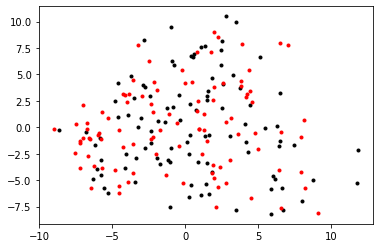

In [23]:
plt.plot(joined_PCA[:100,0], joined_PCA[:100,1], '.', color="black")
plt.plot(joined_PCA[100:,0], joined_PCA[100:,1], '.', color="red")
plt.show()

Based on the above diagram, the populations look mixed, which means that PCA cannot do a satisfactory clustering for this data.